In [2]:
import numpy as np
import sys
import os
import glob
import importlib
import math as m
import pickle as pickle
import seaborn as sns
import statistics
import pandas as pd
fmts = ['svg','pdf']
from scipy.stats import norm, wilcoxon, ttest_rel, friedmanchisquare, shapiro
from scipy import signal, fft
from scipy.optimize import curve_fit, minimize
import matplotlib # produce matlab-style plots
from matplotlib import animation as ani # animation
import matplotlib.pyplot as plt # Matlab-style plotting
from matplotlib import rcParams
matplotlib.rc('font',**{'size':20}) # increase font size on plots
matplotlib.rc('text',usetex=False) # use LaTeX to render symbols
matplotlib.rc('animation',html='html5') # render animation
font = {#'family' : 'normal',
        'weight' : 'ultralight',
        'size'   : 14}
matplotlib.rc('font', **font)
rcParams['axes.titlesize'] = 16
rcParams['font.weight'] = 'ultralight'
rcParams['font.family'] = 'sans-serif'
rcParams['mathtext.fontset'] = 'cm'
prop_cycle = plt.rcParams['axes.prop_cycle']
python_colors = prop_cycle.by_key()['color'] # python default color cycle

# auto reload modules
%load_ext autoreload
%autoreload 2
sys.path.append('C:\\Users\\amber\\Documents\\GitHub\\sensorimotor_fusion\\analysis\\Multimodal paper') # change this for your computer
from globalVars import *
from collect_data import findFilename, getrawdata, get_data, analyze
from analysis import *
# DATA_PATH = 'C:\\Users\\amber\\Documents\\GitHub\\sensorimotor_fusion' #change this for your computer

In [3]:
from globalVars import *
from collect_data import findFilename, getrawdata, get_data, analyze
from analysis import *

In [4]:
print('data length = ',N)
print('primes = ',primes)
print('base freq = ',base_freq)
print('IX = ',IX)
print('Even_IX = ',Even_IX)
print('Odd_IX = ',Odd_IX)
print('freqs = ',freqs)
print('omegas = ',omegas)
print('T = ',T) # total time 40 seconds
print('t = ',t) # timestamps
print('fs = ',fs)
print('sample_period (dt)= ',dt)
print('xf = ',xf) # frequency domain x-axis, shape (N//2,)
print('Machine = ',M) # soM at stimulated freqs
print('scaleInput = ',scaleInput)
print('scaleOutputScreen = ',scaleOutputScreen)

data length =  2400
primes =  [ 2  3  5  7 11 13 17 19]
base freq =  0.05
IX =  [ 4  6 10 14 22 26 34 38]
Even_IX =  [ 6 14 26 38]
Odd_IX =  [ 4 10 22 34]
freqs =  [0.1  0.15 0.25 0.35 0.55 0.65 0.85 0.95]
omegas =  [0.62831853 0.9424778  1.57079633 2.19911486 3.45575192 4.08407045
 5.34070751 5.96902604]
T =  40
t =  [0.00000000e+00 1.66736140e-02 3.33472280e-02 ... 3.99666528e+01
 3.99833264e+01 4.00000000e+01]
fs =  60
sample_period (dt)=  0.016666666666666666
xf =  [0.0000e+00 2.5000e-02 5.0000e-02 ... 2.9925e+01 2.9950e+01 2.9975e+01]
Machine =  [-0.7169568 -1.14107219j -0.52958685-0.5619091j  -0.28840044-0.18360142j
 -0.17134712-0.0779164j  -0.07726649-0.02235881j -0.05656227-0.01384948j
 -0.03387172-0.00634218j -0.02730057-0.00457371j]
scaleInput =  0.04616974606700115
scaleOutputScreen =  0.25


# Load data

In [5]:
# with open('multimodal_data.pkl', 'wb') as file:
#     pickle.dump(ALLdata, file)

# Load the array from the file
with open('multimodal_data.pkl', 'rb') as file:
    Rs,Ds,Us,U0s,U1s,Ys,rs,ds,us,u0s,u1s,ys,errors,Tur,Tu0r,Tu1r,Tud,Tu0d,Tu1d,Tyr,Tyd = pickle.load(file)

In [6]:
print(Rs.shape) # subject x condition x trial x all freqs
print(rs.shape) # subject x condition x trial x timestamps
print(errors.shape) # subject x condition x trial

subject_num = Rs.shape[0]
condition_num = Rs.shape[1]
trial_num = Rs.shape[2]
print('subject_num = ',subject_num)
print('condition_num (alphas) = ',condition_num)
print('trial_num = ',trial_num)
alphas = np.array([0,0.25,0.5,0.75,1])
conditions = ['0','0.25','0.5','0.75','1']

(15, 5, 14, 2400)
(15, 5, 14, 2400)
(15, 5, 14)
subject_num =  15
condition_num (alphas) =  5
trial_num =  14


# FF FB

In [25]:
def FF_FB(Tur,Tud):
    B = - (1 / M) * (Tud / (1+ Tud)) 
    F = (1 + B * M)*Tur - B
    return F,B
def FF_FB_each_modality(Tu0r,Tu0d,Tu1r,Tu1d,w): #w = weighting of EMG
    w0 = w
    w1 = 1-w
    B0 = (- (1/M) * Tu0d) / (1 + w0*Tu0d + w1*Tu1d)
    B1 = (- (1/M) * Tu1d) / (1 + w0*Tu0d + w1*Tu1d)
    F0 = -B0 + Tu0r + w0 * B0 * M * Tu0r + w1 * B0 * M * Tu1r
    F1 = -B1 + Tu1r + w0 * B1 * M * Tu0r + w1 * B1 * M * Tu1r
    return F0,F1,B0,B1

F = np.zeros(Tur.shape, dtype=complex) #number of stimulated freqs = 8
B = np.zeros(Tur.shape, dtype=complex)
for sub in range(subject_num):
    for cond in range(condition_num):
        for i in range(trial_num//2):
            F[sub,cond,i],B[sub,cond,i] = FF_FB(Tur[sub,cond,i],Tud[sub,cond,i])
print(F.shape) # subject x condition x trial//2 x stimulated freqs
print(B.shape)

F0 = np.zeros(Tur.shape, dtype=complex) #number of stimulated freqs = 8
F1 = np.zeros(Tur.shape, dtype=complex) #number of stimulated freqs = 8
B0 = np.zeros(Tur.shape, dtype=complex)
B1 = np.zeros(Tur.shape, dtype=complex)
for sub in range(subject_num):
    for cond in range(condition_num):
        w = alphas[cond]
        for i in range(trial_num//2):
            F0[sub,cond,i],F1[sub,cond,i],B0[sub,cond,i],B1[sub,cond,i] \
                = FF_FB_each_modality(Tu0r[sub,cond,i],Tu0d[sub,cond,i],Tu1r[sub,cond,i],Tu1d[sub,cond,i],w)
print(F0.shape) # subject x condition x trial//2 x stimulated freqs
print(B0.shape)

(15, 5, 7, 8)
(15, 5, 7, 8)
(15, 5, 7, 8)
(15, 5, 7, 8)


## new FF and FB

In [23]:
# F = np.zeros((subject_num,condition_num, trial_num, 8), dtype=complex) #number of stimulated freqs = 8
# B = np.zeros((subject_num,condition_num, trial_num, 8), dtype=complex) 
# F0 = np.zeros((subject_num,condition_num, trial_num, 8), dtype=complex) 
# F1 = np.zeros((subject_num,condition_num, trial_num, 8), dtype=complex) 
# B0 = np.zeros((subject_num,condition_num, trial_num, 8), dtype=complex)
# B1 = np.zeros((subject_num,condition_num, trial_num, 8), dtype=complex)

# for sub in range(subject_num):
#     for cond in range(condition_num):
#         for trial in range(trial_num):
#             for i, ix in enumerate(IX):
#                 r = Rs[sub,cond,trial][ix]
#                 y = Ys[sub,cond,trial][ix]
#                 u = us[sub,cond,trial][ix]
#                 u0 = U0s[sub,cond,trial][ix]
#                 u1 = U1s[sub,cond,trial][ix]

#                 ry = np.vstack((r,y)) # (2x1)
#                 A = u[np.newaxis] @ np.linalg.pinv(ry) # (1x1) @ (1x2) = (1x2)
#                 tur = A[0]
#                 tuy = A[1]
#                 A0 = u0[np.newaxis] @ np.linalg.pinv(ry) # (1x1) @ (1x2) = (1x2)
#                 tu0r = A0[0]
#                 tu0y = A0[1]
#                 A1 = u1[np.newaxis] @ np.linalg.pinv(ry) # (1x1) @ (1x2) = (1x2)
#                 tu1r = A1[0]
#                 tu1y = A1[1]

#                 F[sub,cond,trial,i] = tur + tuy
#                 B[sub,cond,trial,i] = -tuy
#                 F0[sub,cond,trial,i] = tu0r + tu0y
#                 F1[sub,cond,trial,i] = tu1r + tu1y
#                 B0[sub,cond,trial,i] = -tu0y
#                 B1[sub,cond,trial,i] = -tu1y

# People who did well vs bad (0.5 condition)

In [26]:
for cond in range(condition_num):
    subject_errors = np.mean(errors[:,cond,:],axis=1)
    print(subject_errors)
    good_3 = np.argsort(subject_errors)[:3]
    bad_3 = np.argsort(subject_errors)[-3:]
    print(good_3), print(bad_3)

[ 43.90699697  79.69776345  40.61074917  51.99646933 412.49433021
  20.84607665  13.2653314   44.5846609   24.78744246 113.11394587
 813.20158137  47.86721382  34.2915546  259.31830502  49.94240469]
[6 5 8]
[13  4 10]
[36.32377209 74.54539013 40.06511095 43.58725475 76.2691221  10.84667818
 12.16082731 36.16156337 15.79639574 56.18611989 18.58820081 32.15576968
 24.3993632  65.03410188 26.16450689]
[5 6 8]
[13  1  4]
[ 31.89196786 112.75955875  23.50271182  28.07005834  84.74853742
   9.76857965  11.48926092  33.92449681  10.80027085  40.07820105
  15.35589035  32.74748087  29.56813782  22.71362741  18.05145485]
[5 8 6]
[9 4 1]
[ 41.47040672 390.64470682  31.6581804   29.76871431 125.2057941
  16.74807986  16.25464684  54.26323959   9.78230762 102.16275935
  14.98884991  19.6121123   31.38155684  53.73590904  15.92920745]
[ 8 10 14]
[9 4 1]
[ 67.84458064 252.34515683 156.75858403  23.28565459 275.67549129
  12.01801656  13.8844994   43.5697776    8.88363328 150.35863298
  13.25300591  

In [27]:
cond = 2
subject_errors = np.mean(errors[:,cond,:],axis=1)
print(subject_errors)

good_3 = np.argsort(subject_errors)[:3]
bad_3 = np.argsort(subject_errors)[-3:]
print(good_3)
print(bad_3)

[ 31.89196786 112.75955875  23.50271182  28.07005834  84.74853742
   9.76857965  11.48926092  33.92449681  10.80027085  40.07820105
  15.35589035  32.74748087  29.56813782  22.71362741  18.05145485]
[5 8 6]
[9 4 1]


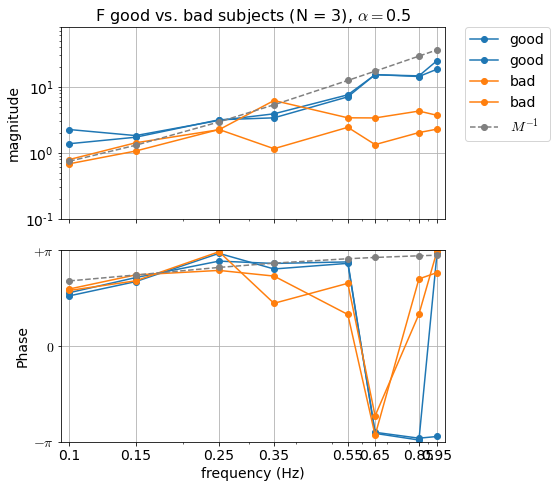

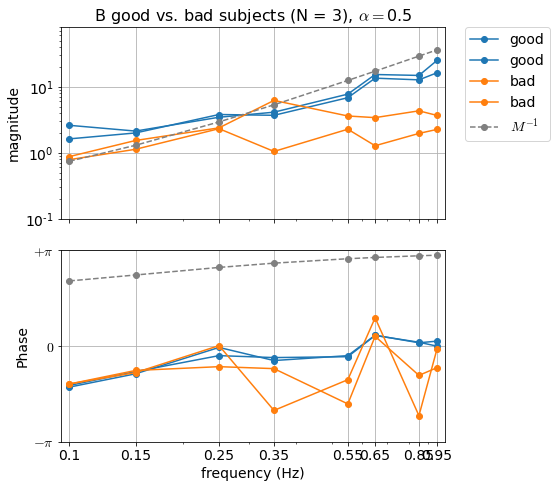

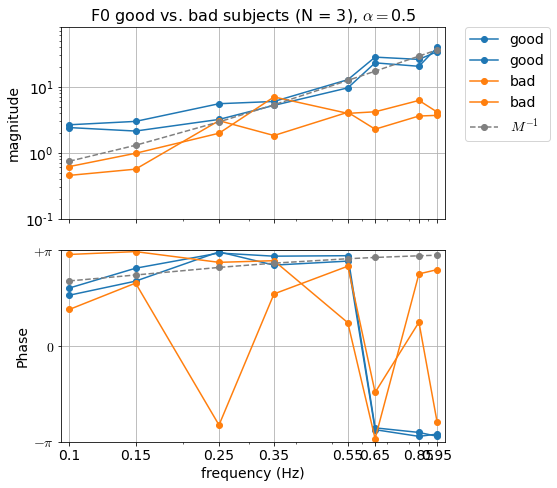

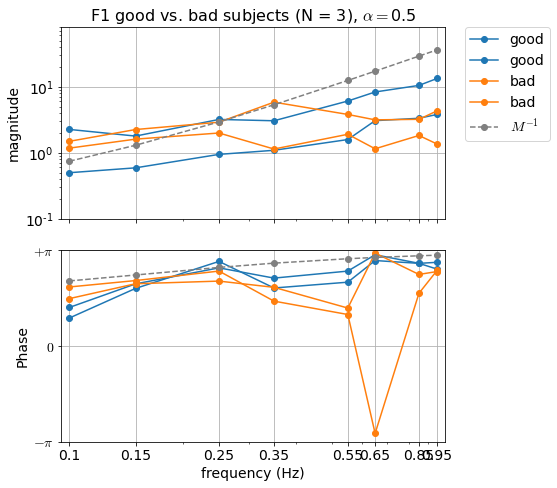

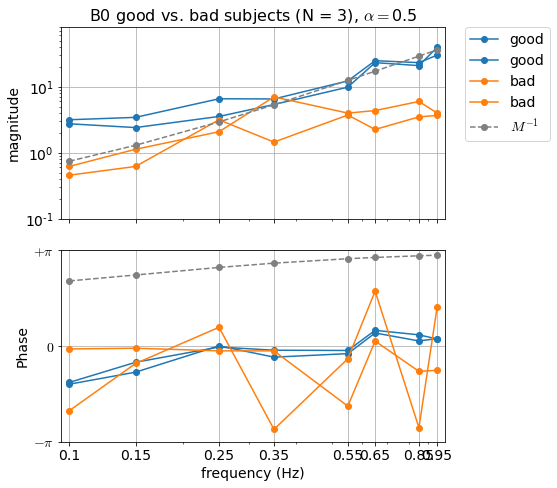

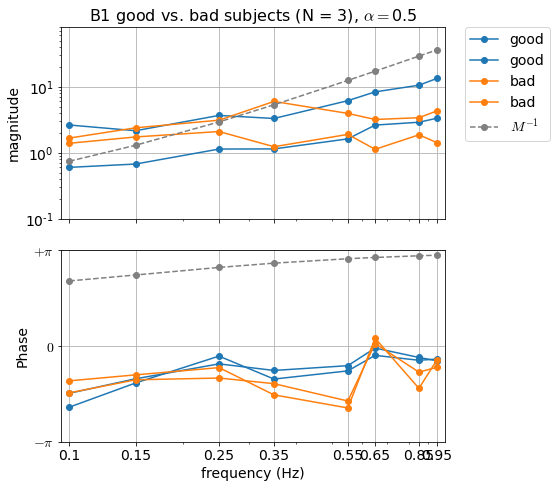

In [28]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi,np.pi)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']
TFlabels = ['F','B','F0','F1','B0','B1']

cond = 2

for i,TF in enumerate([F,B,F0,F1,B0,B1]):
 
    fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,7))

    # magnitude
    ax = axs[0]
    sub = good_3
    mean = np.mean(np.abs(TF[sub,cond,:,:]),axis = 1) #mean across all trials
    # mean = np.abs(TF[sub,cond,-1,:]) # last trial
    ax.plot(freqs,mean[0],'-o',label = 'good',color = python_colors[0])
    ax.plot(freqs,mean[1],'-o',label = 'good',color = python_colors[0])
    # ax.plot(freqs,mean[2],'-o',label = 'good',color = python_colors[0])
    sub = bad_3
    mean = np.mean(np.abs(TF[sub,cond,:,:]),axis = 1) #mean across all trials
    # mean = np.abs(TF[sub,cond,-1,:])
    # ax.plot(freqs,mean[0],'-o',label = 'bad',color = python_colors[1])
    ax.plot(freqs,mean[1],'-o',label = 'bad',color = python_colors[1])
    ax.plot(freqs,mean[2],'-o',label = 'bad',color = python_colors[1])
    ax.plot(freqs,np.abs(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.grid('on',zorder=-1)
    ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    ax.set_ylabel('magnitude')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # phase
    ax = axs[1]
    sub = good_3
    angle = np.angle(np.mean(np.exp(1j*(np.angle(TF[sub,cond,:,:]))),axis = 1))
    # angle = np.angle(TF[sub,cond,-1,:])
    # z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    # mean = np.angle(z)+np.pi/2
    # disp = 1 - np.abs(z)
    ax.plot(freqs,angle[0],'-o',label = 'good',color = python_colors[0])
    ax.plot(freqs,angle[1],'-o',label = 'good',color = python_colors[0])
    # ax.plot(freqs,angle[2],'-o',label = 'good',color = python_colors[0])
    sub = bad_3
    angle = np.angle(np.mean(np.exp(1j*(np.angle(TF[sub,cond,:,:]))),axis = 1))
    # angle = np.angle(TF[sub,cond,-1,:])
    # ax.plot(freqs,angle[0],'-o',label = 'bad',color = python_colors[1])
    ax.plot(freqs,angle[1],'-o',label = 'bad',color = python_colors[1])
    ax.plot(freqs,angle[2],'-o',label = 'bad',color = python_colors[1])
    ax.plot(freqs,np.angle(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_ylabel('Phase') 
    ax.grid('on',zorder=-1)
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[0].set_title(TFlabels[i]+ r' good vs. bad subjects (N = 3), $\alpha = $'+conditions[cond])
    plt.tight_layout()
    plt.show()

## difference in phase for F0 and F1

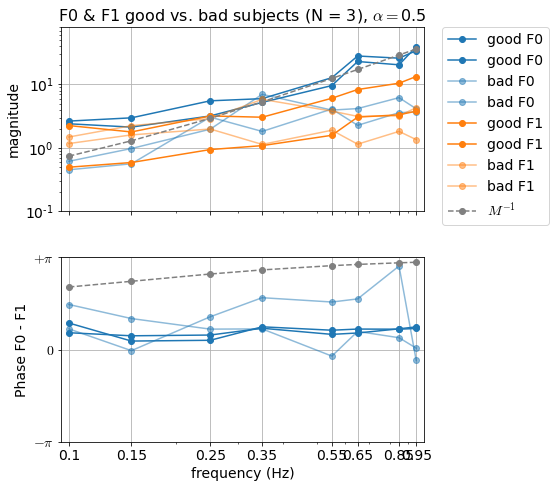

In [74]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi,np.pi)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']
TFlabels = ['F','B','F0','F1','B0','B1']

cond = 2

# for i,TF in enumerate([F,B,F0,F1,B0,B1]):

 
fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,7))

# magnitude
# for TF in [F0,F1]:
ax = axs[0]
sub = good_3
mean = np.mean(np.abs(F0[sub,cond,:,:]),axis = 1) #mean across all trials
# mean = np.abs(TF[sub,cond,-1,:]) # last trial
ax.plot(freqs,mean[0],'-o',label = 'good F0',color = python_colors[0])
ax.plot(freqs,mean[1],'-o',label = 'good F0',color = python_colors[0])
# ax.plot(freqs,mean[2],'-o',label = 'good F0',color = python_colors[0])

sub = bad_3
mean = np.mean(np.abs(F0[sub,cond,:,:]),axis = 1) #mean across all trials
# mean = np.abs(TF[sub,cond,-1,:])
# ax.plot(freqs,mean[0],'-o',label = 'bad',color = python_colors[0])
ax.plot(freqs,mean[1],'-o',label = 'bad F0',color = python_colors[0],alpha = 0.5)
ax.plot(freqs,mean[2],'-o',label = 'bad F0',color = python_colors[0],alpha = 0.5)

sub = good_3
mean = np.mean(np.abs(F1[sub,cond,:,:]),axis = 1) #mean across all trials
# mean = np.abs(TF[sub,cond,-1,:]) # last trial
ax.plot(freqs,mean[0],'-o',label = 'good F1',color = python_colors[1])
ax.plot(freqs,mean[1],'-o',label = 'good F1',color = python_colors[1])
# ax.plot(freqs,mean[2],'-o',label = 'good',color = python_colors[1])

sub = bad_3
mean = np.mean(np.abs(F1[sub,cond,:,:]),axis = 1) #mean across all trials
# mean = np.abs(TF[sub,cond,-1,:])
# ax.plot(freqs,mean[0],'-o',label = 'bad',color = python_colors[1])
ax.plot(freqs,mean[1],'-o',label = 'bad F1',color = python_colors[1],alpha = 0.5)
ax.plot(freqs,mean[2],'-o',label = 'bad F1',color = python_colors[1],alpha = 0.5)


ax.plot(freqs,np.abs(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
ax.set_xscale("log")
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.grid('on',zorder=-1)
ax.set_ylim(0.1,80)
ax.set_yscale("log")
ax.set_ylabel('magnitude')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# phase
ax = axs[1]
sub = good_3
angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[sub,cond,:,:] / F1[sub,cond,:,:]))),axis = 1))
# angle = np.angle(TF[sub,cond,-1,:])
# z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
# mean = np.angle(z)+np.pi/2
# disp = 1 - np.abs(z)
ax.plot(freqs,angle[0],'-o',label = 'good',color = python_colors[0])
ax.plot(freqs,angle[1],'-o',label = 'good',color = python_colors[0])
# ax.plot(freqs,angle[2],'-o',label = 'good',color = python_colors[0])
sub = bad_3
angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[sub,cond,:,:] / F1[sub,cond,:,:]))),axis = 1))
# angle = np.angle(TF[sub,cond,-1,:])
# ax.plot(freqs,angle[0],'-o',label = 'bad',color = python_colors[1])
ax.plot(freqs,angle[1],'-o',label = 'bad',color = python_colors[0],alpha = 0.5)
ax.plot(freqs,angle[2],'-o',label = 'bad',color = python_colors[0],alpha = 0.5)
ax.plot(freqs,np.angle(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
ax.set_ylabel('Phase F0 - F1') 
ax.grid('on',zorder=-1)
ax.set_ylim(ylimphase)
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.set_xlabel('frequency (Hz)')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
axs[0].set_title(r'F0 & F1 good vs. bad subjects (N = 3), $\alpha = $'+conditions[cond])
plt.tight_layout()
plt.show()

## F0 + F1

In [75]:
sub = 5
cond = 2
trial = -1

0.5* (F0[sub,cond,trial,:] + F1[sub,cond,trial,:])

array([ 0.17984917 +0.52438538j, -0.79229009 +0.02982659j,
       -1.7431993  +0.61299537j, -3.42471289 +0.50912468j,
       -3.78014631 +4.60770927j,  2.60983174 +7.55455451j,
       -2.9714202 +18.09665382j, -9.3367065  -2.90286287j])

In [76]:
F[sub,cond,trial,:]

array([ 0.17984917 +0.52438538j, -0.79229009 +0.02982659j,
       -1.7431993  +0.61299537j, -3.42471289 +0.50912468j,
       -3.78014631 +4.60770927j,  2.60983174 +7.55455451j,
       -2.9714202 +18.09665382j, -9.3367065  -2.90286287j])

## subject 5

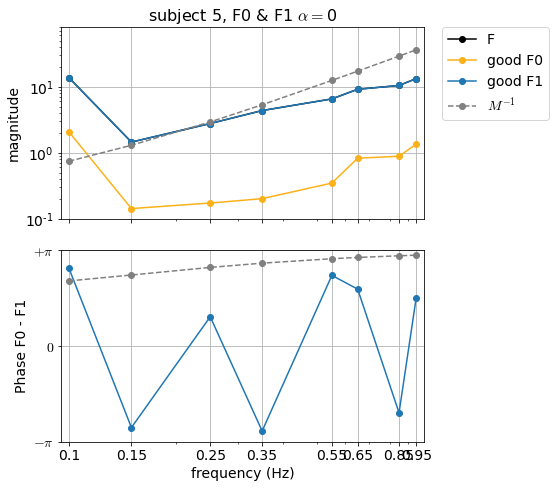

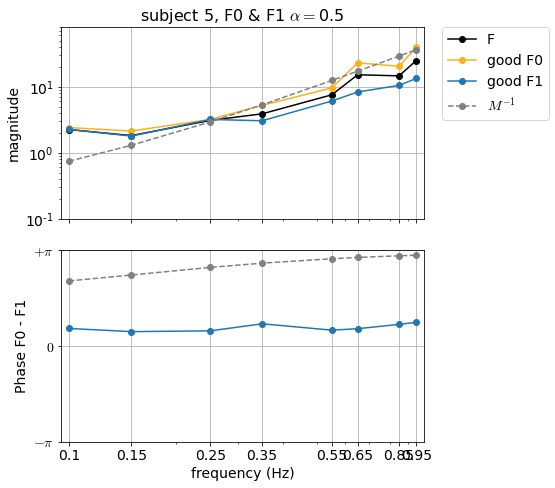

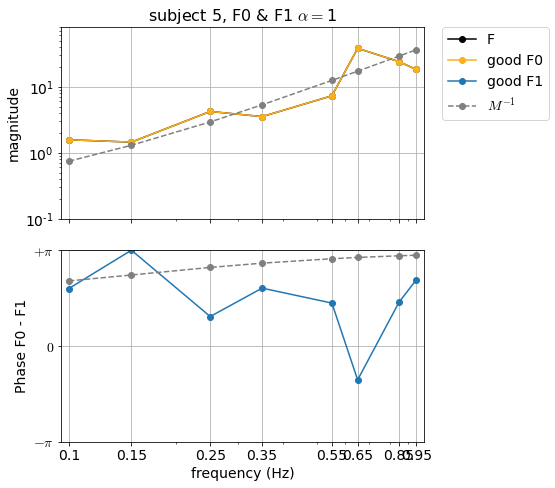

In [95]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi,np.pi)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']
TFlabels = ['F','B','F0','F1','B0','B1']

sub = 5
for cond in [0,2,4]:

    fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,7))

    # magnitude
    ax = axs[0]
    mean = np.mean(np.abs(F[sub,cond,:,:]),axis = 0) #mean across all trials
    ax.plot(freqs,mean,'-o',label = 'F',color = 'black')

    mean = np.mean(np.abs(F0[sub,cond,:,:]),axis = 0) #mean across all trials
    ax.plot(freqs,mean,'-o',label = 'good F0',color = colors['GOLD'])

    mean = np.mean(np.abs(F1[sub,cond,:,:]),axis = 0) #mean across all trials
    ax.plot(freqs,mean,'-o',label = 'good F1',color = colors['BLUE'])

    ax.plot(freqs,np.abs(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.grid('on',zorder=-1)
    ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    ax.set_ylabel('magnitude')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # phase
    ax = axs[1]
    angle_diff = np.angle(F0[sub,cond,:,:] / F1[sub,cond,:,:])
    angle = np.angle(np.mean(np.exp(1j*(angle_diff)),axis = 0))
    # angle = np.angle(TF[sub,cond,-1,:])
    # z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    # mean = np.angle(z)+np.pi/2
    # disp = 1 - np.abs(z)
    ax.plot(freqs,angle,'-o',label = 'good',color = python_colors[0])

    ax.plot(freqs,np.angle(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_ylabel('Phase F0 - F1') 
    ax.grid('on',zorder=-1)
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # axs[0].set_title(r'F0 & F1 good vs. bad subjects (N = 3), $\alpha = $'+conditions[cond])
    axs[0].set_title('subject 5, F0 & F1'+ r' $\alpha = $'+conditions[cond])
    plt.tight_layout()
    plt.show()

## subject 8

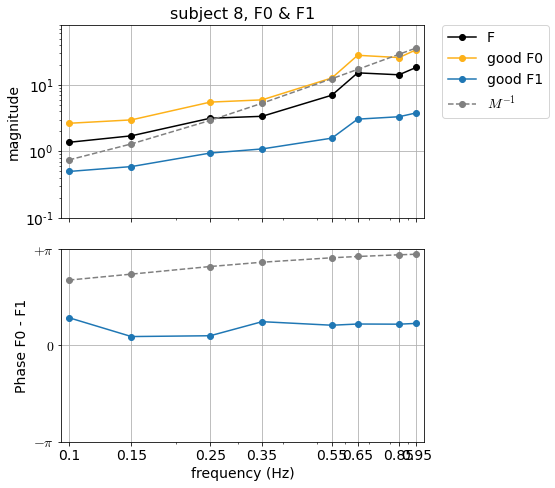

In [88]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi,np.pi)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']
TFlabels = ['F','B','F0','F1','B0','B1']

sub = 8
cond = 2

fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,7))

# magnitude
ax = axs[0]
mean = np.mean(np.abs(F[sub,cond,:,:]),axis = 0) #mean across all trials
ax.plot(freqs,mean,'-o',label = 'F',color = 'black')

mean = np.mean(np.abs(F0[sub,cond,:,:]),axis = 0) #mean across all trials
ax.plot(freqs,mean,'-o',label = 'good F0',color = colors['GOLD'])

mean = np.mean(np.abs(F1[sub,cond,:,:]),axis = 0) #mean across all trials
ax.plot(freqs,mean,'-o',label = 'good F1',color = colors['BLUE'])

ax.plot(freqs,np.abs(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
ax.set_xscale("log")
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.grid('on',zorder=-1)
ax.set_ylim(0.1,80)
ax.set_yscale("log")
ax.set_ylabel('magnitude')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# phase
ax = axs[1]
angle_diff = np.angle(F0[sub,cond,:,:] / F1[sub,cond,:,:])
angle = np.angle(np.mean(np.exp(1j*(angle_diff)),axis = 0))
# angle = np.angle(TF[sub,cond,-1,:])
# z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
# mean = np.angle(z)+np.pi/2
# disp = 1 - np.abs(z)
ax.plot(freqs,angle,'-o',label = 'good',color = python_colors[0])

ax.plot(freqs,np.angle(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
ax.set_ylabel('Phase F0 - F1') 
ax.grid('on',zorder=-1)
ax.set_ylim(ylimphase)
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.set_xlabel('frequency (Hz)')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# axs[0].set_title(r'F0 & F1 good vs. bad subjects (N = 3), $\alpha = $'+conditions[cond])
axs[0].set_title('subject 8, F0 & F1')
plt.tight_layout()
plt.show()

## subject 12

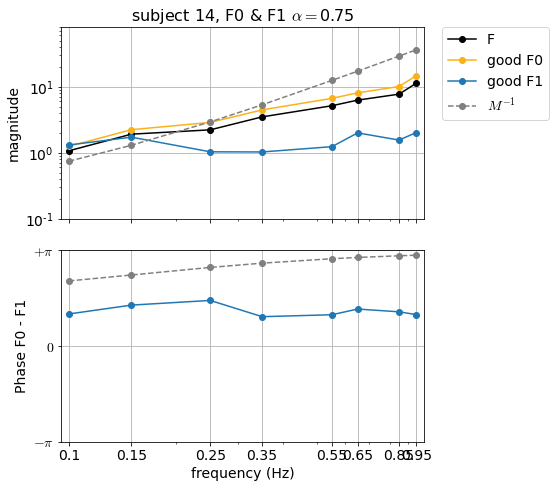

In [106]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi,np.pi)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']
TFlabels = ['F','B','F0','F1','B0','B1']

sub = 14
cond = 3
# for cond in [0,2,4]:

fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,7))

# magnitude
ax = axs[0]
mean = np.mean(np.abs(F[sub,cond,:,:]),axis = 0) #mean across all trials
ax.plot(freqs,mean,'-o',label = 'F',color = 'black')

mean = np.mean(np.abs(F0[sub,cond,:,:]),axis = 0) #mean across all trials
ax.plot(freqs,mean,'-o',label = 'good F0',color = colors['GOLD'])

mean = np.mean(np.abs(F1[sub,cond,:,:]),axis = 0) #mean across all trials
ax.plot(freqs,mean,'-o',label = 'good F1',color = colors['BLUE'])

ax.plot(freqs,np.abs(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
ax.set_xscale("log")
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.grid('on',zorder=-1)
ax.set_ylim(0.1,80)
ax.set_yscale("log")
ax.set_ylabel('magnitude')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# phase
ax = axs[1]
angle_diff = np.angle(F0[sub,cond,:,:] / F1[sub,cond,:,:])
angle = np.angle(np.mean(np.exp(1j*(angle_diff)),axis = 0))
# angle = np.angle(TF[sub,cond,-1,:])
# z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
# mean = np.angle(z)+np.pi/2
# disp = 1 - np.abs(z)
ax.plot(freqs,angle,'-o',label = 'good',color = python_colors[0])

ax.plot(freqs,np.angle(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
ax.set_ylabel('Phase F0 - F1') 
ax.grid('on',zorder=-1)
ax.set_ylim(ylimphase)
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.set_xlabel('frequency (Hz)')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# axs[0].set_title(r'F0 & F1 good vs. bad subjects (N = 3), $\alpha = $'+conditions[cond])
axs[0].set_title('subject 14, F0 & F1'+ r' $\alpha = $'+conditions[cond])
plt.tight_layout()
plt.show()

# Time domain inputs

In [39]:
good_3, bad_3

(array([5, 8, 6], dtype=int64), array([9, 4, 1], dtype=int64))

In [55]:
sub = 1
cond = 2
trial = -1

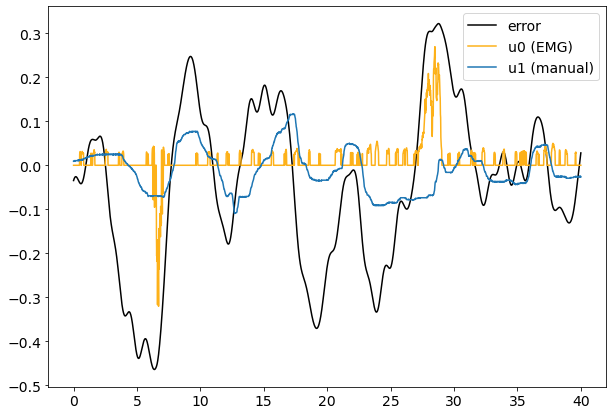

In [56]:
fig,ax = plt.subplots(sharex=True,figsize=(10,7))
ax.plot(t,rs[sub,cond,trial,:]-ys[sub,cond,trial,:],label = 'error',color = 'black')
ax.plot(t,u0s[sub,cond,trial,:],label = 'u0 (EMG)',color = colors['GOLD'])
ax.plot(t,u1s[sub,cond,trial,:],label = 'u1 (manual)',color = colors['BLUE'])
ax.legend()
plt.show()

In [44]:
sub = 5
cond = 2
trial = -1

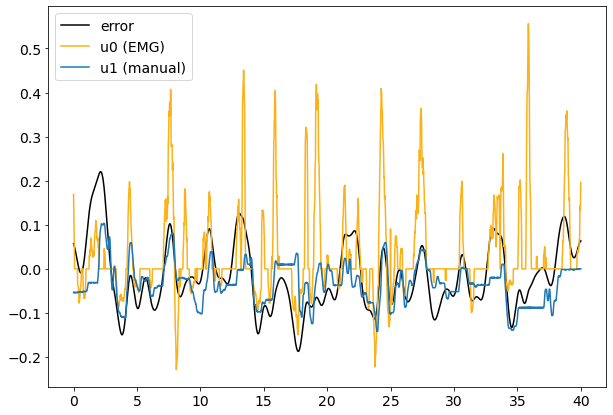

In [45]:
fig,ax = plt.subplots(sharex=True,figsize=(10,7))
ax.plot(t,rs[sub,cond,trial,:]-ys[sub,cond,trial,:],label = 'error',color = 'black')
ax.plot(t,u0s[sub,cond,trial,:],label = 'u0 (EMG)',color = colors['GOLD'])
ax.plot(t,u1s[sub,cond,trial,:],label = 'u1 (manual)',color = colors['BLUE'])
ax.legend()
plt.show()